In [178]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandasdmx as sdmx
from functools import reduce

# Data Fetching & Basic Manipulation

In [75]:
estat = sdmx.Request("ESTAT")

## Carbon Data

In [132]:
resp = estat.data(
	"ENV_AIR_GGE",
	key={
		"unit": "THS_T",
		"freq": "A",
		"src_crf": "TOTX4_MEMONIA",
		"airpol": "GHG"
	}
)
emission_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD'}).droplevel(level=['unit', 'freq', 'src_crf', 'airpol'], axis=1)
emission_df.reset_index(inplace=True)
emission_df["year"] = emission_df["TIME_PERIOD"].dt.year
emission_df.drop("TIME_PERIOD", inplace=True, axis=1)
emission_melted_df = pd.melt(emission_df, id_vars="year")

emission_melted_df.head()

2024-06-04 23:17:27,003 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


,year,geo,value
0,1985,AT,NaN
1,1986,AT,NaN
2,1987,AT,NaN
3,1988,AT,NaN
4,1989,AT,NaN


In [ ]:
px.scatter(emission_melted_df, x="TIME_PERIOD", y="value", color="geo")

## Energy Data

In [153]:
def get_melted_energy_dfs(code: str) -> pd.DataFrame:
	"""
	A quick helper to get, parse, and melt the dataframes for a given energy `nrg_bal`.

	:param code: The `nrg_bal` code to fetch and melt
	:returns: A melted dataframe
	"""
	resp = estat.data(
		"NRG_D_HHQ",
		key={
			"siec": "TOTAL",
			"unit": "TJ",
			"nrg_bal": code,
			"freq": "A",
		}
	)
	household_energy_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD', 'freq': 'freq'}).droplevel(level=["siec", "unit", "nrg_bal"], axis=1)

	household_energy_df.reset_index(inplace=True)
	household_energy_df["year"] = household_energy_df["TIME_PERIOD"].dt.year
	household_energy_df.drop("TIME_PERIOD", inplace=True, axis=1)
	household_energy_melted_df = pd.melt(household_energy_df, id_vars="year")
	household_energy_melted_df.columns = ["year", "geo", code]
	return household_energy_melted_df

In [598]:
codes = ["FC_OTH_HH_E_SH", "FC_OTH_HH_E_SC", "FC_OTH_HH_E_WH", "FC_OTH_HH_E_CK", "FC_OTH_HH_E"]
energy_dfs = [get_melted_energy_dfs(code) for code in codes]

2024-06-05 21:23:32,675 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'Y' instead.

2024-06-05 21:23:32,827 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'Y' instead.

2024-06-05 21:23:33,017 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'Y' instead.

2024-06-05 21:23:33,194 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for 

In [599]:
resp = estat.data(
	"TEN00127",
	key={
		"unit": "KTOE",
		"freq": "A",
		"siec": "O4652XR5210B",
		"nrg_bal": "FC_TRA_ROAD_E"
	}
)
gas_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD'}).droplevel(level=['unit', 'freq', 'siec', "nrg_bal"], axis=1)
gas_df.reset_index(inplace=True)
gas_df["year"] = gas_df["TIME_PERIOD"].dt.year
gas_df.drop("TIME_PERIOD", inplace=True, axis=1)
gas_melted_df = pd.melt(gas_df, id_vars="year")

gas_melted_df.head()

2024-06-05 21:23:35,400 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


,year,geo,value
0,2011,AL,115.592
1,2012,AL,100.745
2,2013,AL,109.229
3,2014,AL,109.229
4,2015,AL,109.229


## Merge Datasets

In [703]:
to_merge_dfs = [emission_melted_df, *energy_dfs, gas_melted_df]
columns = ["year", "geo", "carbon", "energy_heating", "energy_cooling", "energy_water_heating", "energy_cooking", "total", "gas"]
res_carbon_df = reduce(lambda l, r: pd.merge(l, r, left_on=["year", "geo"], right_on=["year", "geo"]), to_merge_dfs)
res_carbon_df.columns = columns
res_carbon_df.head()

,year,geo,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas
0,2011,AT,84795.76,190731.846,25.123,41343.612,6891.695,274577.058,1632.260
1,2012,AT,81981.39,195419.278,34.215,41839.251,7026.774,279812.556,1585.826
2,2013,AT,82304.13,205494.885,31.035,41541.823,7353.560,289591.863,1554.830
3,2014,AT,78716.82,178513.717,27.645,42495.391,7152.047,261676.431,1524.254
4,2015,AT,81081.58,193886.979,25.714,42104.965,7179.133,278096.422,1539.983


In [704]:
res_carbon_df.drop(index=72, axis=0, inplace=True)

In [705]:
res_carbon_df.head()

,year,geo,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas
0,2011,AT,84795.76,190731.846,25.123,41343.612,6891.695,274577.058,1632.260
1,2012,AT,81981.39,195419.278,34.215,41839.251,7026.774,279812.556,1585.826
2,2013,AT,82304.13,205494.885,31.035,41541.823,7353.560,289591.863,1554.830
3,2014,AT,78716.82,178513.717,27.645,42495.391,7152.047,261676.431,1524.254
4,2015,AT,81081.58,193886.979,25.714,42104.965,7179.133,278096.422,1539.983


In [706]:
res_carbon_df.iloc[:, 2:].corr()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas
carbon,1.000000,0.953864,0.860277,0.953774,0.958315,0.955910,0.996810
energy_heating,0.953864,1.000000,0.927136,0.994901,0.993171,0.999384,0.957210
energy_cooling,0.860277,0.927136,1.000000,0.927544,0.933284,0.932756,0.871485
energy_water_heating,0.953774,0.994901,0.927544,1.000000,0.994353,0.996930,0.958951
energy_cooking,0.958315,0.993171,0.933284,0.994353,1.000000,0.995190,0.960897
total,0.955910,0.999384,0.932756,0.996930,0.995190,1.000000,0.959333
gas,0.996810,0.957210,0.871485,0.958951,0.960897,0.959333,1.000000


In [707]:
res_carbon_df.drop(res_carbon_df[(res_carbon_df.geo == "EU27_2020") | (res_carbon_df.geo == "EU20")].index, inplace=True)

In [708]:
res_carbon_df.drop("year", axis=1, inplace=True)

## Missing Data

In [709]:

def fill_holes():
	"""
	"""
	lin_reg = lambda X, Y: np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))

	dfs = []

	for name, group in res_carbon_df.groupby('geo'):
		cols = [[name for _ in range(len(group.index))]]
		for i in range(1, len(group.columns)):
			d = group.iloc[:, i:i+1].to_numpy()

			missing_mask = np.isnan(d) | (d == 0)
			present_mask = ~missing_mask

			missing_mask = missing_mask.reshape(1, -1)[0]
			present_mask = present_mask.reshape(1, -1)[0]

			if not np.any(missing_mask):
				d = d.reshape(1, -1)[0]
				cols.append(d)
				continue

			if not np.any(present_mask):
				d = d.reshape(1, -1)[0]
				cols.append(d)
				continue

			x_present = np.pad(np.arange(len(d))[present_mask].reshape(-1, 1), ((0, 0), (1, 0)), mode="constant", constant_values=1)
			y_present = d[present_mask]

			w = lin_reg(x_present, y_present)

			x_missing = np.pad(np.arange(len(d))[missing_mask].reshape(-1, 1), ((0, 0), (1, 0)), mode="constant", constant_values=1)
			y_missing_pred = np.matmul(x_missing, w)

			d[missing_mask] = y_missing_pred
			d = d.reshape(1, -1)[0]

			cols.append(d)
		# print(cols)
		dfs.append(pd.DataFrame(cols).T)	
		# print(dfs)
	df = pd.concat(dfs, axis=0)
	df.columns = res_carbon_df.columns
	return df

res_carbon_df = fill_holes()
res_carbon_df.head()

,geo,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas
0,AT,84795.76,190731.846,25.123,41343.612,6891.695,274577.058,1632.26
1,AT,81981.39,195419.278,34.215,41839.251,7026.774,279812.556,1585.826
2,AT,82304.13,205494.885,31.035,41541.823,7353.56,289591.863,1554.83
3,AT,78716.82,178513.717,27.645,42495.391,7152.047,261676.431,1524.254
4,AT,81081.58,193886.979,25.714,42104.965,7179.133,278096.422,1539.983


## Standardize

In [710]:
df_merged_s = pd.DataFrame()
for feat in res_carbon_df.columns:
	if feat == "geo": continue
	df_merged_s[f'{feat}'] = ((res_carbon_df[feat] - res_carbon_df[feat].mean()) / res_carbon_df[feat].std())
df_merged_s["geo"] = res_carbon_df["geo"]
# df_merged_s["year"] = res_carbon_df["year"]
df_merged_s.head()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas,geo
0,-0.278063,-0.151182,-0.520127,-0.16618,-0.443228,-0.194221,-0.20869,AT
1,-0.292585,-0.13864,-0.516839,-0.159931,-0.439427,-0.184739,-0.222157,AT
2,-0.29092,-0.111683,-0.517989,-0.163681,-0.430231,-0.167029,-0.231146,AT
3,-0.309431,-0.183871,-0.519215,-0.151659,-0.435901,-0.217583,-0.240014,AT
4,-0.297228,-0.14274,-0.519914,-0.156581,-0.435139,-0.187847,-0.235452,AT


## Dummies

In [711]:
df_dummies = pd.get_dummies(df_merged_s, dtype=int, columns=["geo"])
print(df_dummies.shape)
df_dummies.head()

(335, 35)


,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas,geo_AT,geo_BE,geo_BG,...,geo_LV,geo_MT,geo_NL,geo_NO,geo_PL,geo_PT,geo_RO,geo_SE,geo_SI,geo_SK
0,-0.278063,-0.151182,-0.520127,-0.16618,-0.443228,-0.194221,-0.20869,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.292585,-0.13864,-0.516839,-0.159931,-0.439427,-0.184739,-0.222157,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.29092,-0.111683,-0.517989,-0.163681,-0.430231,-0.167029,-0.231146,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.309431,-0.183871,-0.519215,-0.151659,-0.435901,-0.217583,-0.240014,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.297228,-0.14274,-0.519914,-0.156581,-0.435139,-0.187847,-0.235452,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [712]:
df_dummies = df_dummies.fillna(0)

/var/folders/jk/vqmr1l1d1dnflmyh1qdjmhk40000gn/T/ipykernel_66892/3693932479.py:1: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [713]:
df_dummies.drop(["energy_cooling", "energy_heating", "energy_water_heating", "energy_cooking"], axis=1, inplace=True)

## Linear Regression

In [714]:
X = np.pad(df_dummies.iloc[:, 1:].to_numpy(), ((0,0), (1,0)), mode="constant", constant_values=1)
y = np.array(df_dummies["carbon"])
X[0:2,]

array([[ 1.        , -0.19422063, -0.2086896 ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.        , -0.18473927, -0.22215674,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [715]:
m = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
np.set_printoptions(suppress=True) #this just prevents python from printing it out in inconvenient scientific notation
m

array([  56.20252722,  127.95282355,   43.70567339,  -24.29766787,
        -44.87242756,   24.04409072,   48.15089027,   -7.80834782,
       -715.48225259,   -2.65882844,   40.86351043,  -17.92484837,
       -162.67244527,    4.80913169, -438.8064785 ,   38.26739083,
         -0.98892811,   14.71399105, -353.58122047,   45.08681054,
         58.88487034,   33.86351043,   63.92759016,  -87.57534671,
         14.38389138, -198.7054641 ,    9.95865107,  -34.07436775,
        -45.87242756,   28.10817045,   43.28875074])

In [716]:
# get the residuals
res = y - np.matmul(X, m)
print(res[0:5])
round(sum(res), 1)

[ 1.78907501  1.14997642 -0.72151283  6.11610034  2.12409377]


1173.1

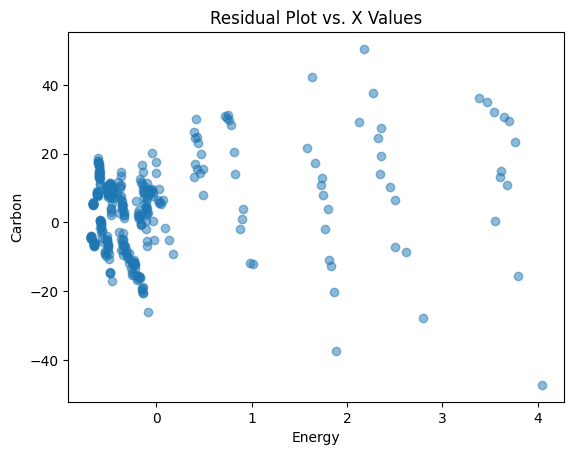

In [717]:
# x values versus residuals
plt.scatter(X[:, 1:2], res, alpha=0.5)
plt.xlabel("Energy")
plt.ylabel("Carbon")
plt.title("Residual Plot vs. X Values")
plt.show()

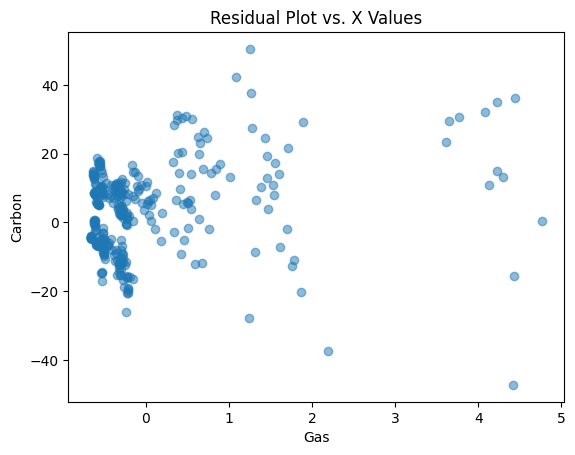

In [757]:
# x values versus residuals
plt.scatter(X[:, 2:3], res, alpha=0.5)
plt.xlabel("Gas")
plt.ylabel("Carbon")
plt.title("Residual Plot vs. X Values")
plt.show()

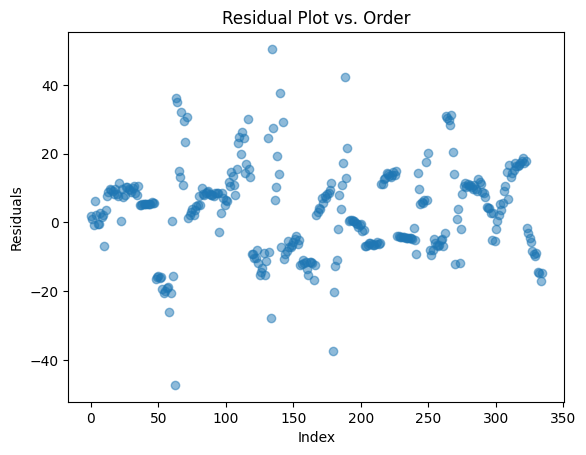

In [758]:
# residuals versus order
plt.scatter(range(len(X[:,1:2])), res, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Order")
plt.show()

In [719]:
px.scatter(df_merged_s, y="carbon", x="total", color="geo")

In [753]:
import matplotlib.cm as cm

Text(0, 0.5, 'Carbon Emissions')

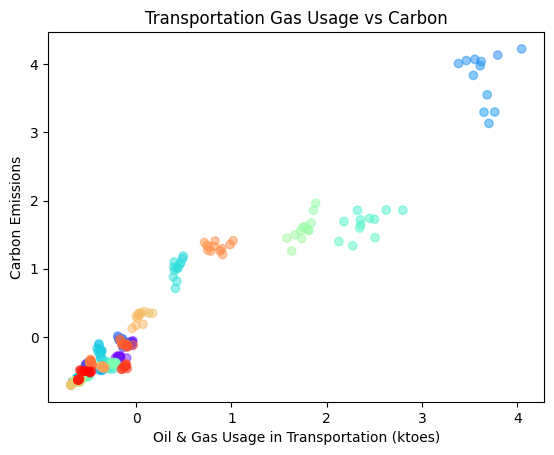

In [756]:
colors = cm.rainbow(np.linspace(0, 1, len(df_merged_s)))
plt.scatter(x=df_merged_s["total"], y=df_merged_s["carbon"], color=colors, alpha=0.5)
plt.title("Transportation Gas Usage vs Carbon")
plt.xlabel("Oil & Gas Usage in Transportation (ktoes)")
plt.ylabel("Carbon Emissions")

In [720]:
from sklearn.metrics import r2_score

In [721]:
from numpy.linalg import det

In [722]:
np_remove = lambda a, i: np.concatenate([a[:i,], a[i + 1:,]])
lin_reg = lambda X, Y: np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))

def loo_cv_pred(X, Y):
	"""
	Predict Y values using leave one out cross validation

	:param X: The X features array (including bias column)
	:param Y: The true Y values
	:return: An array of the predicted Y-Vals
	"""
	y_pred = []
	for i in range(len(X)):
		holdout_X = X[i]
		
		loo_X = np_remove(X, i)
		loo_y = np_remove(Y, i)
		loo_b = lin_reg(loo_X, loo_y)

		y_hat = np.matmul(holdout_X, loo_b)
		y_pred.append(y_hat)
	
	return y_pred

In [723]:
preds = loo_cv_pred(X, y)

In [724]:
r2_score(y, preds)

0.8419084630885562

# Experiment: Model per country

In [725]:
df_be = df_merged_s.loc[df_merged_s["geo"] == "BE"]
df_be.head()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas,geo
0,-0.056699,0.056867,-0.568738,-0.197789,-0.478802,-0.034514,-0.335104,BE
1,-0.072725,0.049004,-0.550216,-0.195549,-0.478933,-0.040696,-0.344081,BE
2,-0.073381,0.04114,-0.531693,-0.193309,-0.479064,-0.046878,-0.344678,BE
3,-0.101798,0.033276,-0.513171,-0.19107,-0.479195,-0.05306,-0.319312,BE
4,-0.078167,0.025413,-0.494649,-0.18883,-0.479326,-0.059242,-0.296488,BE


In [742]:
X_be = np.array(np.pad(df_be.iloc[:, 5:6].to_numpy(), ((0,0), (1,0)), mode="constant", constant_values=1), dtype=np.float64)
y_be = np.array(df_be["carbon"])
X_be[0:2,]

array([[ 1.        , -0.03451352],
       [ 1.        , -0.04069572]])

In [743]:
beta_be = lin_reg(X_be, y_be)

In [744]:
res_be = y_be - np.matmul(X_be, beta_be)
print(res_be[0:5])
round(sum(res_be), 1)

[0.015909982113676932 0.004008857952391476 0.007476999077431337
 -0.016814565780291363 0.010940996033058412]


0.0

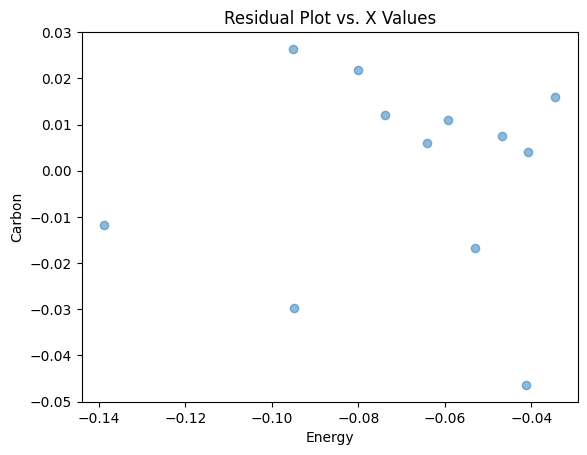

In [745]:
# x values versus residuals
plt.scatter(X_be[:, 1:2], res_be, alpha=0.5)
plt.xlabel("Energy")
plt.ylabel("Carbon")
plt.title("Residual Plot vs. X Values")
plt.show()

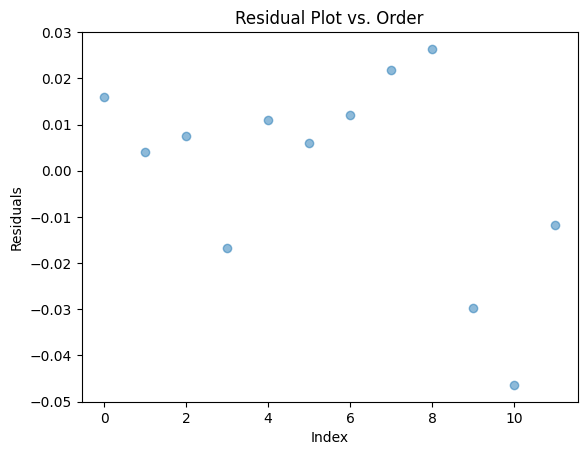

In [746]:
# residuals versus order
plt.scatter(range(len(X_be[:,1:2])), res_be, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Order")
plt.show()

In [747]:
px.scatter(df_be, x="total", y="carbon")

In [748]:
preds_be = loo_cv_pred(X_be, y_be)

In [749]:
r2_score(y_be, preds_be)

0.1960374425066873